In [1]:
# Fix PYTHONPATH to point `vae` directory as root
import sys
from pathlib import Path

cwd = Path(".").resolve()
print(f"Current directory: {cwd.resolve()}")
vae_rootdir = cwd.parent
print(f"VAE root directory: {vae_rootdir}")

sys.path.append(str(vae_rootdir))

Current directory: D:\Projects\Variational-autoencoder\vae\notebooks
VAE root directory: D:\Projects\Variational-autoencoder\vae


# Variational Autoecoder

This notebook contains training process of the VAE with 2-dimensional latent size. Reconstruction is visualized through 2-dimensional manifold.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm
from torch.optim import Adam
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from vae.callbacks import PlotCallback
from vae.model import VAE
from vae.train import Trainer
from vae.utils import load_model, save_model
from config import *

Let's set training and model parameters

In [6]:
# Training params
batch_size = 64
lr = 0.001
device = "cuda"

# Model params
input_size = 784
hidden_size = 512
latent_size = 2

Load data set and create data loader

In [7]:
# Load data set
dataset = MNIST(DATA_DIR, transform=ToTensor(), download=True)

# Create data loader
data_loader = DataLoader(dataset=dataset, batch_size=batch_size)

Initialize model and optimizer

In [8]:
# Initialize model
model = VAE(input_size, hidden_size, latent_size)

# Initialize optimizer
optimizer = Adam(model.parameters(), lr=lr)

Now that we have our dataset, model and optimizer ready, only that's left is to initialize the `Trainer` and run training.

In [9]:
# Initialize trainer
trainer = Trainer(model=model,
                  data_loader=data_loader,
                  optimizer=optimizer,
                  device=device)

Run training for number of epochs.

In [ ]:
losses = trainer.run_train_loop(epochs=150)

Plot losses during training

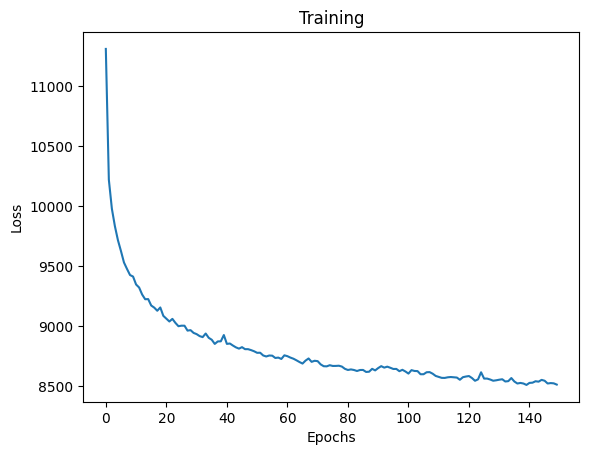

In [11]:
plt.plot(np.arange(len(losses)), losses)
plt.title("Training")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Let's see how the 2-dim manifold of these numbers appear. Firstly, we create 20 samples for x-axis and y-axis with equal quantile range.

In [12]:
x = norm.ppf(np.linspace(0.011, 0.99, 20))
y = norm.ppf(np.linspace(0.011, 0.99, 20))

print(x)

[-2.29036788 -1.5339066  -1.205254   -0.97178425 -0.78200689 -0.61695689
 -0.46725732 -0.32739596 -0.1936869  -0.06336773  0.0658796   0.19624162
  0.33004174  0.47005491  0.61999184  0.78541459  0.97581148  1.21045261
  1.54208627  2.32634787]


Then we create all combinations of (x,y) for 20x20 grid. Each of this combination will be ran though the model to generate an image.

In [13]:
inputs = [(i, j) for i in x for j in y]

Prepare inputs, model and generate samples

In [23]:
# Convert inputs to tensor
inputs_t = torch.tensor(inputs, dtype=torch.float32).to(device)  

print("Input tensor shape: {}".format(inputs_t.size()))

Input tensor shape: torch.Size([400, 2])


In [24]:
# Set model to evaluation mode and genereate samples from inputs
model.eval()  
with torch.no_grad():
    outputs = model.decoder(inputs_t)

In [25]:
# Convert outputs to numpy array and reshape them to image size
outputs = outputs.cpu().numpy()
outputs = outputs.reshape(20, 20, 28, 28)

print("Output tensor shape: {}".format(outputs.shape))

Output tensor shape: (20, 20, 28, 28)


Lastly, plot samples on 20x20 grid.

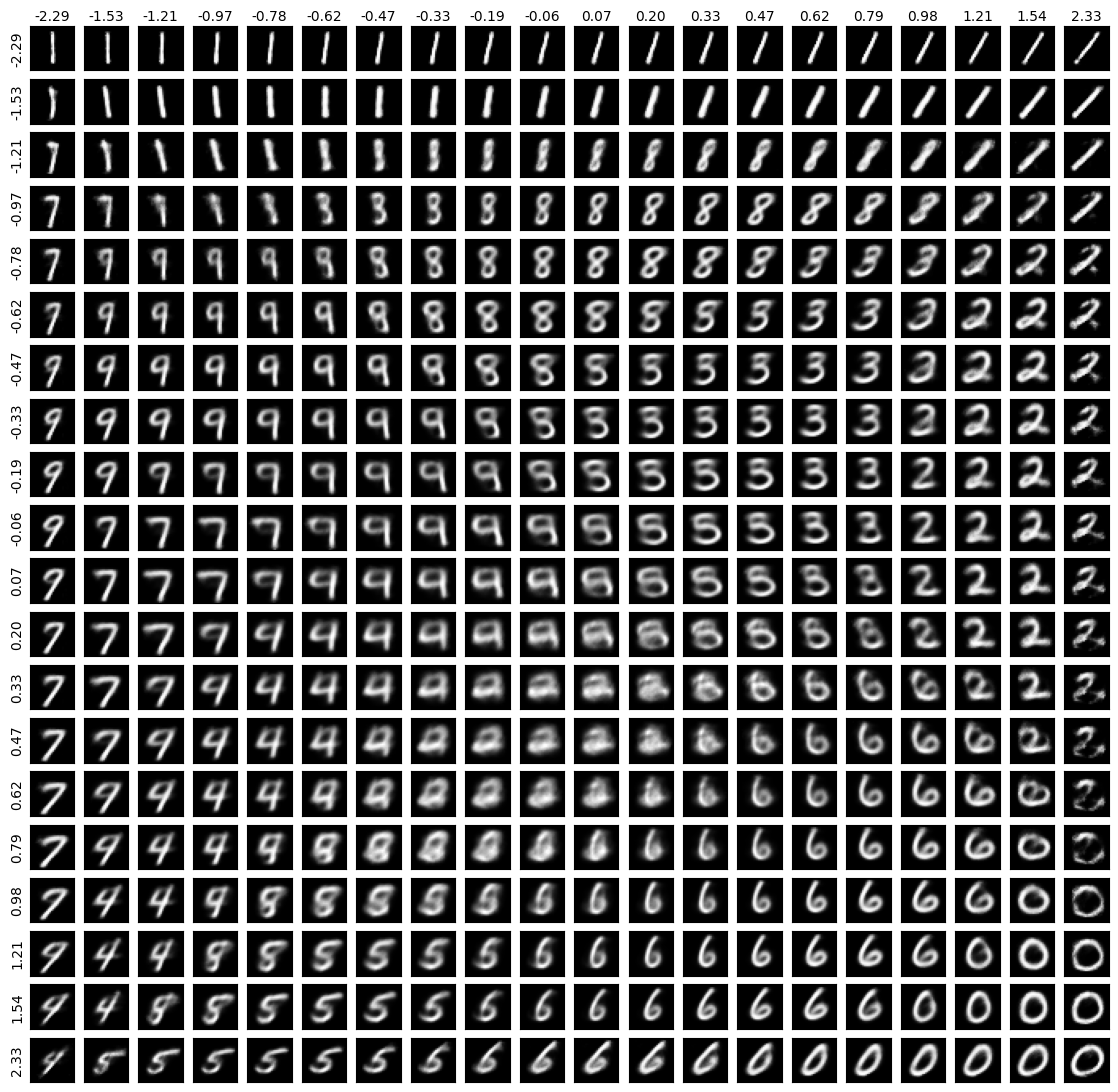

In [26]:
fig, axes = plt.subplots(20, 20, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(0, 0)
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        axes[i][j].imshow(outputs[i][j], cmap='gray')
        
        if j == 0:
            axes[i][j].set_ylabel("{:.2f}".format(y[i]))
        if i == 0:
            axes[i][j].set_xlabel("{:.2f}".format(x[j]))
            axes[i][j].xaxis.set_label_position('top') 